<a href="https://colab.research.google.com/github/LaviWhite/Story-Annotation/blob/main/Product_Detection/Product_Detection_ERNIE_(pythorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

from transformers import BertConfig, BertForSequenceClassification, BertTokenizer, AdamW
from transformers import ErnieConfig, ErnieForSequenceClassification, AutoTokenizer, ErnieModel, AutoModelForSequenceClassification, AutoConfig, AutoTokenizer

from sklearn.model_selection import train_test_split

In [ ]:
import warnings
warnings.filterwarnings('ignore')
path_prefix = './'

# Define Training

In [ ]:

def load_data(data, label=True):
    # 带标签的train
    if label:
        # 因为csv中用1、2代表负面、正面，需要转换为0、1
        return list(data['content']), [y for y in data['label']]
    # 不带标签的train、test
    return list(data['content'])


class CommentDataset(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.label = y

    def __getitem__(self, idx):
        # 不带标签的train、test
        if self.label is None:
            return self.data[idx]
        # 带标签的train
        return self.data[idx], self.label[idx]

    def __len__(self):
        return len(self.data)

def convert_text_to_ids(tokenizer, text, max_len=250):
    # 如果text是str（一句话，不是list）
    if isinstance(text, str):
        tokenized_text = tokenizer.encode_plus(text, max_length=max_len, truncation=True, add_special_tokens=True)
        input_ids = tokenized_text["input_ids"]
        token_type_ids = tokenized_text["token_type_ids"]
    # 如果text是list
    else:
        input_ids = []
        token_type_ids = []
        # 将text中的每一个sentence转化
        for t in text:
            tokenized_text = tokenizer.encode_plus(t, max_length=max_len, truncation=True, add_special_tokens=True)
            input_ids.append(tokenized_text["input_ids"])
            token_type_ids.append(tokenized_text["token_type_ids"])
    return input_ids, token_type_ids

# padding（虽然covert_text_to_ids限制了max length，但是bert tokenizer不会自动padding）
def seq_padding(tokenizer, sentences):
    # 把pad加入到id中
    pad_id = tokenizer.convert_tokens_to_ids("[PAD]")
    # 只有一句话，不用pad
    if len(sentences) <= 1:
        return torch.tensor(sentences)

    # sentences有多句话
    # 获取每个句子的长度
    L = [len(sen) for sen in sentences]
    # 获取最长句子的长度
    ML = max(L)
    # pad到sentences中最长的那句话的长度，不够长的用pad的id补充
    sentences = torch.Tensor([sen + [pad_id] * (ML - len(sen)) if len(sen) < ML else sen for sen in sentences])

    return sentences


# ### 2、Train
def bert_training(batch_size, n_epoch, lr, train, valid, model, tokenizer, model_dir, device):
    '''
    model_dir: 模型参数保存地址
    train: train dataset loader
    valid: valid dataset loader
    model: bert model
    tokenizer: bert的tokenizer
    device: cuda
    '''
    # 记录train和valid 的loss和acc
    train_loss = []
    valid_loss = []
    train_accs = []
    valid_accs = []
    #criterion = nn.BCELoss()

    model.train()
    t_batch = len(train)
    v_batch = len(valid)

    # 设置optimizer参数
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = optim.Adam(optimizer_grouped_parameters, lr=lr)

    best_acc = 0

    for epoch in range(n_epoch):
        # 记录本个epoch的total loss和acc
        total_loss, total_acc = 0, 0
        # training
        for i, (inputs, labels) in enumerate(train):
            # 将inputs list中的每个sentence转化为用ids表示
            input_ids, token_type_ids = convert_text_to_ids(tokenizer, inputs)
            # 将sentence进行padding
            input_ids = seq_padding(tokenizer, input_ids)
            token_type_ids = seq_padding(tokenizer, token_type_ids)
            # 因为要之后要用criterion，去掉最外面一层
            labels = labels.squeeze()
            # 转化为LongTensor
            input_ids, token_type_ids, labels = input_ids.long(), token_type_ids.long(), labels.long()
            input_ids, token_type_ids, labels = input_ids.to(device), token_type_ids.to(device), labels.to(device)
            # 每个batch开始时要清0
            optimizer.zero_grad()

            output = model(input_ids=input_ids, token_type_ids=token_type_ids, labels=labels)
            # 得到output label
            y_pred_prob = output[1]
            y_pred_labels = y_pred_prob.argmax(dim=1)

            # 得到loss，反向传播
            loss = output[0]
            loss.backward()
            # 更新参数
            optimizer.step()

            # 计算正确的数量
            correct =((y_pred_labels == labels.view(-1)).sum()).item()
            # 更新本个epoch的total acc、total loss
            total_acc += (correct / batch_size)
            total_loss += loss.item()
        print('[ Epoch{} ]: \nTrain | Loss:{:.5f} Acc: {:.3f}'.format(epoch+1, total_loss/t_batch, total_acc/t_batch*100))

        # 记录该epoch的training平均loss、acc
        train_loss.append(total_loss/t_batch)
        train_accs.append(total_acc/t_batch)

        # validation
        model.eval()
        with torch.no_grad():
            total_loss, total_acc = 0, 0
            for i, (inputs, labels) in enumerate(valid):
                # 将inputs list中的每个sentence转化为用ids表示
                input_ids, token_type_ids = convert_text_to_ids(tokenizer, inputs)
                # 将sentence进行padding
                input_ids = seq_padding(tokenizer, input_ids)
                token_type_ids = seq_padding(tokenizer, token_type_ids)
                # 因为要之后要用criterion，去掉最外面一层
                labels = labels.squeeze()
                # 转化为LongTensor
                input_ids, token_type_ids, labels = input_ids.long(), token_type_ids.long(), labels.long()
                input_ids, token_type_ids, labels = input_ids.to(device), token_type_ids.to(device), labels.to(device)
                # 得到output label
                output = model(input_ids=input_ids, token_type_ids=token_type_ids, labels=labels)
                y_pred_prob = output[1]
                y_pred_labels = y_pred_prob.argmax(dim=1).squeeze()

                # 得到loss
                loss = output[0]
                # 计算正确的数量
                correct = ((y_pred_labels == labels.view(-1)).sum()).item()
                # 记录该batch的validation平均loss、acc
                total_acc += (correct / batch_size)
                total_loss += loss.item()

            print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss/v_batch, total_acc/v_batch*100))
            # 记录该epoch的validation平均loss、acc
            valid_loss.append(total_loss/v_batch)
            valid_accs.append(total_acc/v_batch)

            if total_acc > best_acc:
                # 如果 validation 的结果比之前最好的结果好，则保留本个epoch的参数
                best_acc = total_acc
                torch.save(model, "{}/ckpt.model".format(model_dir))
                print('saving model with acc {:.3f}'.format(total_acc/v_batch*100))

        print('-----------------------------------------------')

        # 准备进入下一个epoch，调整model模式为train
        model.train()

    return train_loss, train_accs, valid_loss, valid_accs




Some weights of ErnieForSequenceClassification were not initialized from the model checkpoint at nghuyong/ernie-3.0-medium-zh and are newly initialized: ['classifier.weight', 'classifier.bias', 'ernie.pooler.dense.weight', 'ernie.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[ Epoch1 ]: 
Train | Loss:0.61210 Acc: 65.132
Valid | Loss:0.55512 Acc: 62.054 
saving model with acc 62.054
-----------------------------------------------
[ Epoch2 ]: 
Train | Loss:0.56118 Acc: 71.875
Valid | Loss:0.51319 Acc: 62.054 
-----------------------------------------------
[ Epoch3 ]: 
Train | Loss:0.50141 Acc: 74.507
Valid | Loss:0.42427 Acc: 72.768 
saving model with acc 72.768
-----------------------------------------------
[ Epoch4 ]: 
Train | Loss:0.42715 Acc: 79.276
Valid | Loss:0.43080 Acc: 67.857 
-----------------------------------------------
[ Epoch5 ]: 
Train | Loss:0.33210 Acc: 85.526
Valid | Loss:0.34561 Acc: 77.679 
saving model with acc 77.679
-----------------------------------------------
[ Epoch6 ]: 
Train | Loss:0.24807 Acc: 89.967
Valid | Loss:0.35350 Acc: 75.893 
-----------------------------------------------
[ Epoch7 ]: 
Train | Loss:0.19753 Acc: 89.967
Valid | Loss:0.44178 Acc: 74.107 
-----------------------------------------------
[ Epoch8 ]: 
Trai

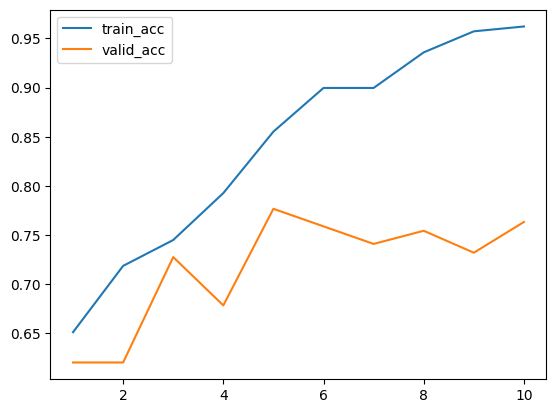

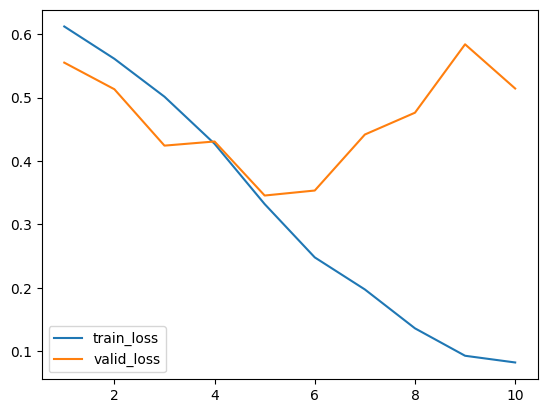

In [ ]:
model_dir = path_prefix

batch_size = 32
epoch = 10
lr = 0.00001
weight_decay = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_data = pd.read_excel('/content/drive/MyDrive/Dissertation/product_detection_1000.xlsx', index_col= 'index')

train, test = train_test_split(train_data, test_size = 0.2, random_state = 2)

train_x, train_y = load_data(train)

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y , test_size = 0.25, random_state = 1)

train_dataset = CommentDataset(X=X_train, y=y_train)
val_dataset = CommentDataset(X=X_val, y=y_val)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                      batch_size = batch_size,
                      shuffle = True,
                      num_workers = 8)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                     batch_size = batch_size,
                     shuffle = False,
                     num_workers = 8)

    # 初始化Bert模型
#config = AutoConfig("nghuyong/ernie-1.0-base-zh")
model = AutoModelForSequenceClassification.from_pretrained("nghuyong/ernie-3.0-medium-zh")
model.to(device)
tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-3.0-medium-zh")

train_loss, train_accs, valid_loss, valid_accs = bert_training(batch_size, epoch, lr, train_loader, val_loader, model, tokenizer, model_dir, device)

    # 绘制训练过程的曲线图
fig = plt.figure()
plt.plot(list(range(1, 1+epoch)), train_accs, label='train_acc')
plt.plot(list(range(1, 1+epoch)), valid_accs, label='valid_acc')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(list(range(1, 1+epoch)), train_loss, label='train_loss')
plt.plot(list(range(1, 1+epoch)), valid_loss, label='valid_loss')
plt.legend()
plt.show()

# Define Testing

In [ ]:

class CommentDataset(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.label = y

    def __getitem__(self, idx):
        # 不带标签的train、test
        if self.label is None:
            return self.data[idx]
        # 带标签的train
        return self.data[idx], self.label[idx]

    def __len__(self):
        return len(self.data)


# 用index替换word来表示每个句子，并将句子统一成一个长度
def convert_text_to_ids(tokenizer, text, max_len=250):
    # 如果text是str（一句话，不是list）
    if isinstance(text, str):
        tokenized_text = tokenizer.encode_plus(text, max_length=max_len, truncation=True, add_special_tokens=True)
        input_ids = tokenized_text["input_ids"]
        token_type_ids = tokenized_text["token_type_ids"]
    # 如果text是list
    else:
        input_ids = []
        token_type_ids = []
        # 将text中的每一个sentence转化
        for t in text:
            tokenized_text = tokenizer.encode_plus(t, max_length=max_len, truncation=True, add_special_tokens=True)
            input_ids.append(tokenized_text["input_ids"])
            token_type_ids.append(tokenized_text["token_type_ids"])
    return input_ids, token_type_ids


# padding（虽然covert_text_to_ids限制了max length，但是bert tokenizer不会自动padding）
def seq_padding(tokenizer, sentences):
    # 把pad加入到id中
    pad_id = tokenizer.convert_tokens_to_ids("[PAD]")
    # 只有一句话，不用pad
    if len(sentences) <= 1:
        return torch.tensor(sentences)

    # sentences有多句话
    # 获取每个句子的长度
    L = [len(sen) for sen in sentences]
    # 获取最长句子的长度
    ML = max(L)
    # pad到sentences中最长的那句话的长度，不够长的用pad的id补充
    sentences = torch.Tensor([sen + [pad_id] * (ML - len(sen)) if len(sen) < ML else sen for sen in sentences])

    return sentences


def testing(batch_size, test_loader, model, device):
    model.eval()
    ret_output = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            # 将inputs list中的每个sentence转化为用ids表示
            input_ids, token_type_ids = convert_text_to_ids(tokenizer, inputs)
            # 将sentence进行padding
            input_ids = seq_padding(tokenizer, input_ids)
            token_type_ids = seq_padding(tokenizer, token_type_ids)
            # 转化为LongTensor
            input_ids, token_type_ids = input_ids.long(), token_type_ids.long()
            input_ids, token_type_ids = input_ids.to(device), token_type_ids.to(device)

            # 得到output label
            output = model(input_ids=input_ids, token_type_ids=token_type_ids)
            y_pred_prob = output[0]
            y_pred_labels = y_pred_prob.argmax(dim=1).squeeze()

            # 正面、负面label分别为2、1，而模型输出是1、0，需要+1处理
            ret_temp = [y for y in y_pred_labels.int().tolist()]
            ret_output += ret_temp

    return ret_output



In [ ]:
y_true = test['label']
x_test = test[['content']]


In [ ]:

batch_size = 32
epoch = 10
lr = 0.00001
weight_decay = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_x = load_data(x_test, label = False)
test_dataset = CommentDataset(X=test_x, y=None)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                      batch_size = batch_size,
                      shuffle = False,
                      num_workers = 8)

model = AutoModelForSequenceClassification.from_pretrained("nghuyong/ernie-3.0-medium-zh")
model.to(device)
tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-3.0-medium-zh")



model = torch.load(os.path.join(model_dir, '/content/ckpt.model'))
outputs = testing(batch_size, test_loader, model, device)

tmp = pd.DataFrame({"id":[str(i) for i in range(len(test_x))],"value":outputs})
tmp.to_csv('/content/drive/My Drive/Dissertation/Dissertation_predict_ernie_20230702.csv', index=False)

Some weights of ErnieForSequenceClassification were not initialized from the model checkpoint at nghuyong/ernie-3.0-medium-zh and are newly initialized: ['classifier.weight', 'classifier.bias', 'ernie.pooler.dense.weight', 'ernie.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tmp.head()

,id,value
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, tmp['value']))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77        84
           1       0.84      0.81      0.82       116

    accuracy                           0.80       200
   macro avg       0.79      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200

